<a href="https://colab.research.google.com/github/fathanzys/NLP-Fathan/blob/main/Analisis_Sentimen_Presiden_Jokowi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analisis Komentar Pada Postingan Kabur Aja Dulu TIKTOK**

Sample :
Tiktok

#**Library**

In [43]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk sastrawi wordcloud

In [44]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
try:
    from indonesian_nlp.sentiment import SentimentAnalyzer
    analyzer = SentimentAnalyzer()
    USE_INDONESIAN_NLP = True
except ImportError:
    print("indonesian-nlp tidak ditemukan, pakai metode manual lexicon sederhana")
    USE_INDONESIAN_NLP = False

indonesian-nlp tidak ditemukan, pakai metode manual lexicon sederhana


#**Data Collection**

In [46]:
df = pd.read_csv('/content/data_scrapper_jokowi.csv')  # Sesuaikan path file
df = df[['text']]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Jumlah data: {len(df)}")
df.head()

Jumlah data: 521


,text
0,beredar video sidang ijazah palsu Jokowi di PN...
1,Jokowi Tak Serahkan Langsung Semua Ijazah ke B...
2,"Tuduhan Ijazah Palsu, Jokowi Merasa Dihina Seh..."
3,"Didesak Tunjukan Ijazah Asli Jokowi ke Publik,..."
4,"detik detik hakim disoraki antek antek jokowi,..."


#**Preprocessing Text**

In [47]:
stemmer = StemmerFactory().create_stemmer()
stopword_factory = StopWordRemoverFactory()
stopword = stopword_factory.get_stop_words()

# Jangan hapus kata negasi
negasi = ['tidak', 'bukan', 'kurang', 'nggak', 'ga', 'enggak', 'tak']
stopword = [w for w in stopword if w not in negasi]

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [word for word in words if word not in stopword]
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(preprocess)
df[['text', 'clean_text']].head()

,text,clean_text
0,beredar video sidang ijazah palsu Jokowi di PN...,edar video sidang ijazah palsu jokowi pn jakar...
1,Jokowi Tak Serahkan Langsung Semua Ijazah ke B...,jokowi tak serah langsung semua ijazah bareskr...
2,"Tuduhan Ijazah Palsu, Jokowi Merasa Dihina Seh...",tuduh ijazah palsu jokowi rasa hina hina hina
3,"Didesak Tunjukan Ijazah Asli Jokowi ke Publik,...",desak tunjuk ijazah asli jokowi publik acara j...
4,"detik detik hakim disoraki antek antek jokowi,...",detik detik hakim sorak antek antek jokowi hak...


#**Labelling Sentimen**

In [60]:
def get_sentiment(text):
    if USE_INDONESIAN_NLP:
        result = analyzer.analyze_sentiment(text)
        return result['label']
    else:
        # Simple manual lexicon-based fallback (contoh sederhana)
        positif_words = ['bagus', 'baik', 'senang', 'presiden', 'puas', 'benar', 'asli']
        negatif_words = ['ijazahpalsu', 'mulyono', 'adili', 'bohong', 'tolol', 'hoax', 'palsu']
        text_words = text.split()
        pos_count = sum([1 for w in text_words if w in positif_words])
        neg_count = sum([1 for w in text_words if w in negatif_words])
        if pos_count > neg_count:
            return 'positif'
        elif neg_count > pos_count:
            return 'negatif'
        else:
            return 'netral'

df['sentimen'] = df['clean_text'].apply(get_sentiment)
df['sentimen'].value_counts()

,count
sentimen,
netral,284
negatif,143
positif,94


#**Modelling**

In [61]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])
y = df['sentimen']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Ukuran Data Latih:", X_train.shape)
print("Ukuran Data Uji:", X_test.shape)

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))

Ukuran Data Latih: (416, 5000)
Ukuran Data Uji: (105, 5000)
Akurasi: 0.8857142857142857


#**Evaluation**

In [69]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

     negatif       0.96      0.86      0.91        29
      netral       0.85      0.96      0.90        57
     positif       0.93      0.68      0.79        19

    accuracy                           0.89       105
   macro avg       0.91      0.84      0.87       105
weighted avg       0.89      0.89      0.88       105



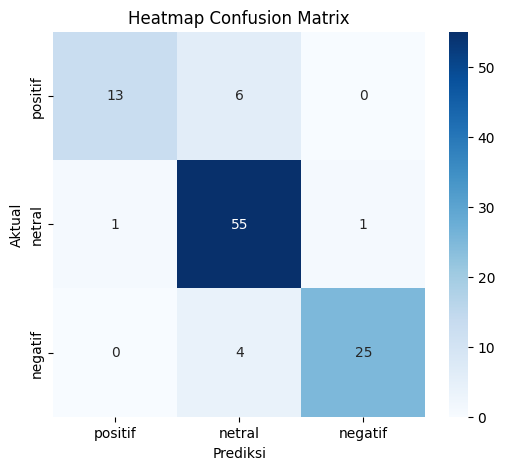

In [68]:
cm_df = pd.DataFrame(cm, index=['positif', 'netral', 'negatif'], columns=['positif', 'netral', 'negatif'])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

#**Visualisasi**

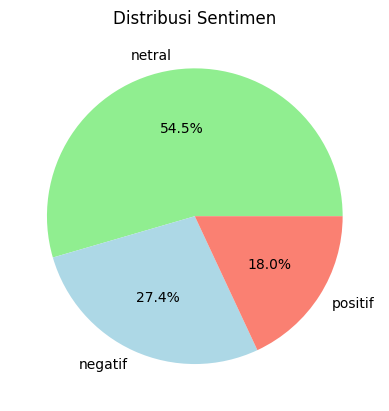

In [63]:
df['sentimen'].value_counts().plot.pie(
    autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'salmon'])
plt.title("Distribusi Sentimen")
plt.ylabel("")
plt.show()


<ipython-input-70-6d8990495d2c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentimen', y='text_length', data=df, palette='Set2')


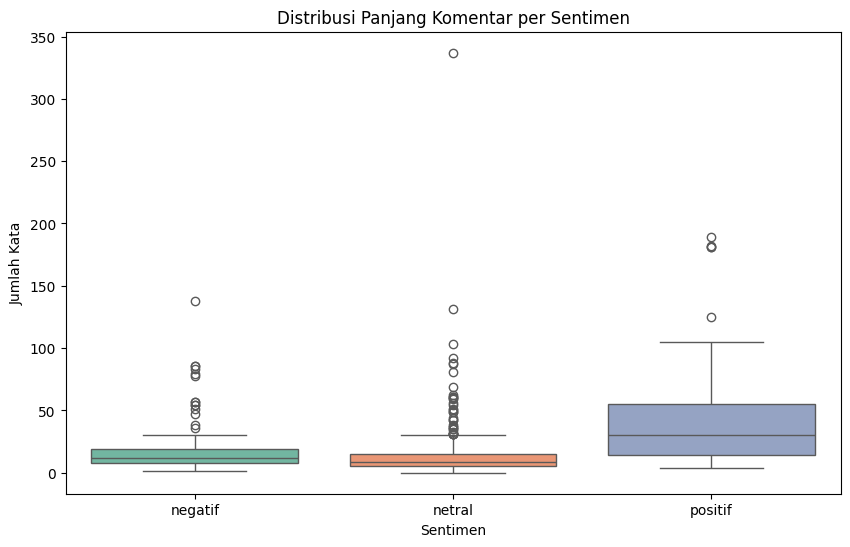

In [70]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentimen', y='text_length', data=df, palette='Set2')
plt.title('Distribusi Panjang Komentar per Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Kata')
plt.show()

<ipython-input-72-02e597c7b8fd>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='muted')


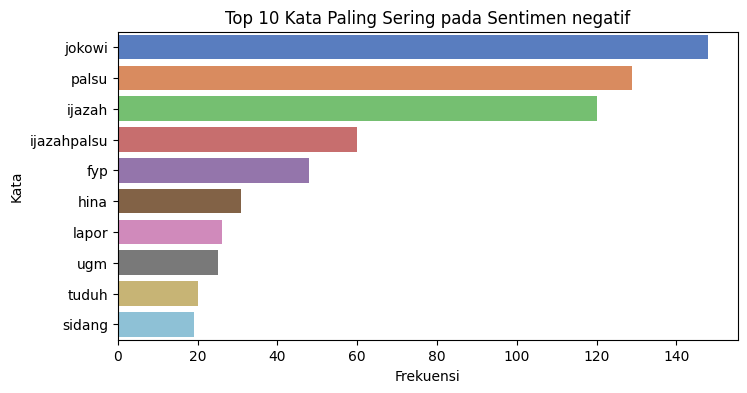

In [72]:
from collections import Counter

def plot_top_words(sentiment, n=10):
    text = " ".join(df[df['sentimen'] == sentiment]['clean_text'])
    words = text.split()
    counter = Counter(words)
    top = counter.most_common(n)
    words, counts = zip(*top)

    plt.figure(figsize=(8,4))
    sns.barplot(x=list(counts), y=list(words), palette='muted')
    plt.title(f"Top {n} Kata Paling Sering pada Sentimen {sentiment}")
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata")
    plt.show()

for s in ['negatif']:
    plot_top_words(s)

<ipython-input-73-c852016d834d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='muted')


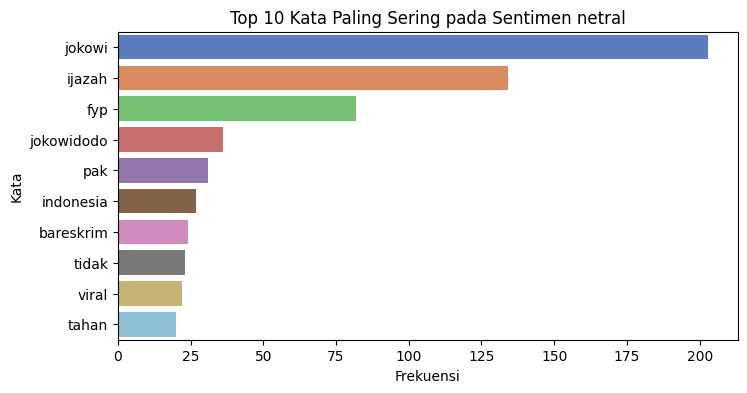

In [73]:
from collections import Counter

def plot_top_words(sentiment, n=10):
    text = " ".join(df[df['sentimen'] == sentiment]['clean_text'])
    words = text.split()
    counter = Counter(words)
    top = counter.most_common(n)
    words, counts = zip(*top)

    plt.figure(figsize=(8,4))
    sns.barplot(x=list(counts), y=list(words), palette='muted')
    plt.title(f"Top {n} Kata Paling Sering pada Sentimen {sentiment}")
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata")
    plt.show()

for s in ['netral']:
    plot_top_words(s)

<ipython-input-74-afe58cf64058>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='muted')


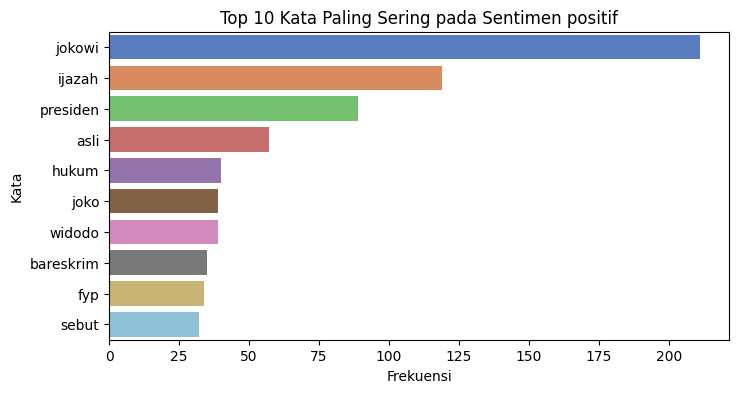

In [74]:
from collections import Counter

def plot_top_words(sentiment, n=10):
    text = " ".join(df[df['sentimen'] == sentiment]['clean_text'])
    words = text.split()
    counter = Counter(words)
    top = counter.most_common(n)
    words, counts = zip(*top)

    plt.figure(figsize=(8,4))
    sns.barplot(x=list(counts), y=list(words), palette='muted')
    plt.title(f"Top {n} Kata Paling Sering pada Sentimen {sentiment}")
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata")
    plt.show()

for s in ['positif']:
    plot_top_words(s)

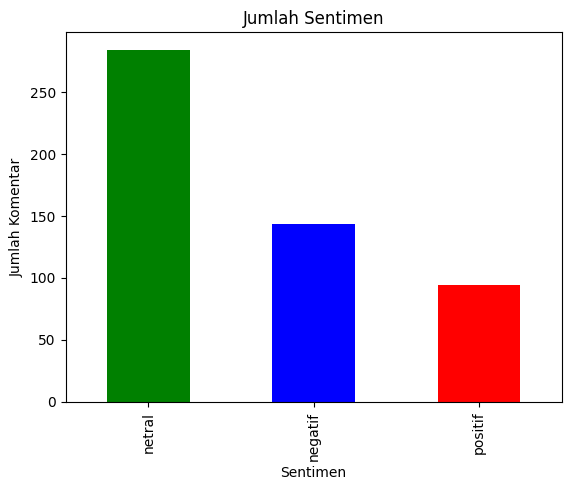

In [64]:
df['sentimen'].value_counts().plot(
    kind='bar', color=['green', 'blue', 'red'])
plt.title("Jumlah Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Komentar")
plt.show()

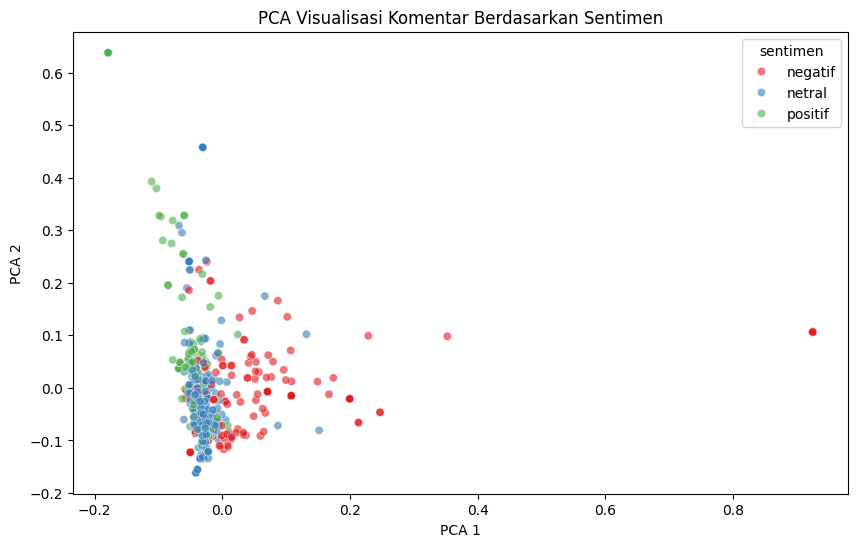

In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

df_pca = pd.DataFrame()
df_pca['x'] = X_pca[:,0]
df_pca['y'] = X_pca[:,1]
df_pca['sentimen'] = y

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_pca, x='x', y='y', hue='sentimen', palette='Set1', alpha=0.6)
plt.title('PCA Visualisasi Komentar Berdasarkan Sentimen')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

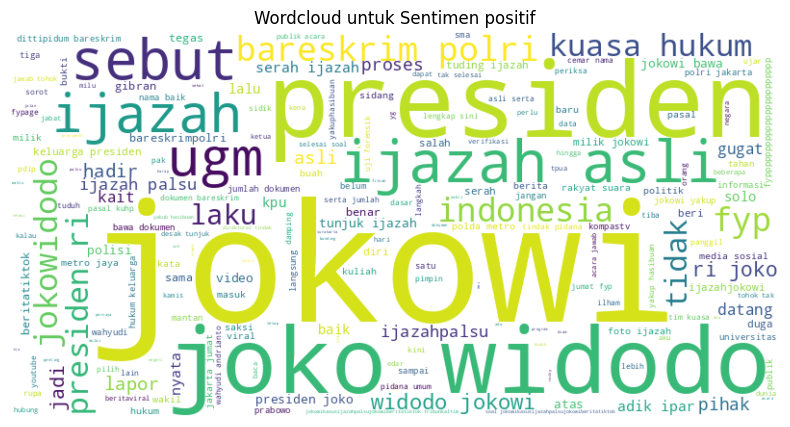

In [65]:
for kategori in ['positif']:
    teks = " ".join(df[df['sentimen'] == kategori]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(teks)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud untuk Sentimen {kategori}")
    plt.show()

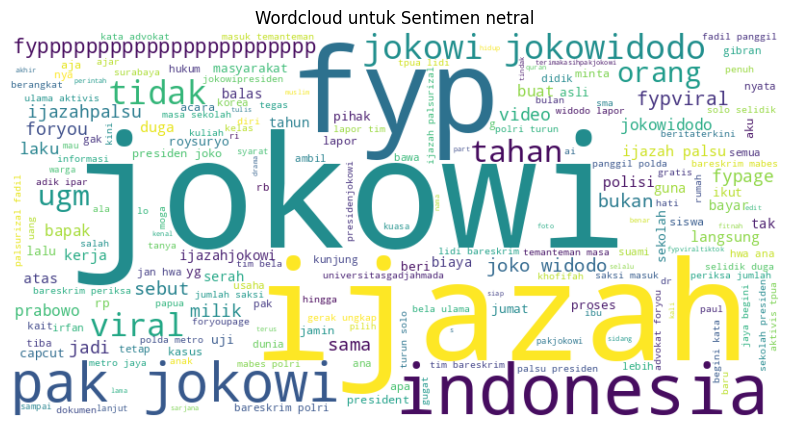

In [66]:
for kategori in ['netral']:
    teks = " ".join(df[df['sentimen'] == kategori]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(teks)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud untuk Sentimen {kategori}")
    plt.show()

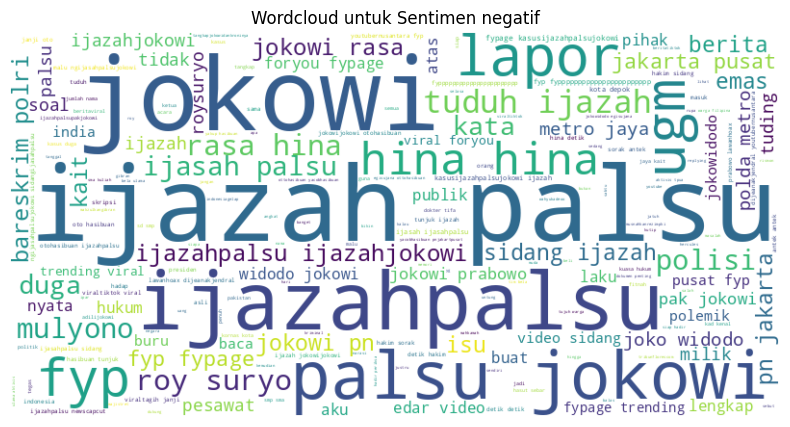

In [67]:
for kategori in ['negatif']:
    teks = " ".join(df[df['sentimen'] == kategori]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(teks)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud untuk Sentimen {kategori}")
    plt.show()